# Self-Organizing Map (SOM) Classifier.

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 2.0
* **Fecha:** Marzo 2024

## Summary.

The present notebook covers the process of clustering; it starts with the data import process, the exploratory statistical analysis aiming to spot any possible issues within the data, the determination of the optimal number of clusters, the clustering process and to conclusion, a brief analysis of the resulting classes. 

This NoteBook focuses on the implementation of the clustering method known as "Self-Organazing maps"; a link to the library used for the clustering process is provided as well as documentation regarding the basics of the method.
Self-organising maps rely on dimensional reduction to cluster similar data around nodes mapped from the dimension of the data into a dimensional-reduced space.

**Referrence to the library used for SOM.**

https://som-pbc.readthedocs.io/en/latest/readme.html

### Libraries.

In [1]:
## Standard Libraries.
import os
import time
import math
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr

## Clustering analysis libraries.
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data visualization libraries. 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image

## Data science libraries.
from sklearn.preprocessing import StandardScaler

# SOM library.
from som import SOM

**Functions**

In [2]:
from Funciones.GraphStatEng import *

### Data Import.

The input data set contains well logs from 19 wells, these wells had been cropped to cover data corresponding to the same formation, a sandy-shale. Four well logs were loaded, those relevant to determine the lithology; electric logs were excluded to minimize the impact of fluid content in the clustering process. 

In [3]:
Data = ['DEPT','Well_ID','ECGR','RHOZ','DTCO','NPHI','Arcilla','PoroFluido','Sw']
Well_logs = ['ECGR','RHOZ','DTCO','NPHI']

In [4]:
currdir = os.getcwd()
df_CHTC = pd.read_csv(currdir + '\\Datos\\Datos_registros_nucleos_CHTC.csv', usecols=Data, na_values=-999.25)
df_CHTC_labeled = df_CHTC.copy()
df_CHTC_labeled.dropna(axis=0, inplace=True)
df_CHTC.head(5)

,Well_ID,DEPT,ECGR,RHOZ,DTCO,NPHI,Arcilla,PoroFluido,Sw
0,A3,1126.0836,107.9460,2.3803,110.1317,0.3453,0.462965,0.161557,0.786636
1,A3,1126.2360,105.3806,2.3843,108.8417,0.3369,0.458999,0.157529,0.797815
2,A3,1126.3884,92.6494,2.4006,106.4857,0.3735,0.514268,0.148046,0.821726
3,A3,1126.5408,85.2163,2.4185,105.1499,0.3418,0.478424,0.139049,0.777045
4,A3,1126.6932,80.9719,2.4253,104.4066,0.3387,0.480614,0.134676,0.799551


In [5]:
print('%i samples were loaded' %df_CHTC_labeled.shape[0])

75238 samples were loaded


## Exploratory Data Analysis.

**Univariate analysis**

Exploratory data analysis was conducted to verify the data set's regularity and ensure it was suitable for the clustering analysis. The first stage of the analysis consisted of univariate analysis, in which statistics were presented next to the histogram and boxplot of each property.
Bivariate analysis was conducted using linear correlation coefficients and a pair plot, and lastly, multivariate analysis was conducted focusing on finding multivariate outliers. 

In [6]:
df_Estadigrafos = Estadigrafos(df_CHTC, Well_logs).round(2)
#df_Estadigrafos.to_csv(currdir + '\Resultados\\Estadigrafos.csv')
df_Estadigrafos

,ECGR,RHOZ,DTCO,NPHI
Samples,75238.00,75238.00,75238.00,75238.00
Minimum,13.81,1.88,45.69,0.02
1st quartile,50.23,2.51,74.64,0.20
Median,61.74,2.55,84.67,0.25
Mean,60.25,2.54,83.23,0.24
3rd quartile,70.33,2.58,90.81,0.28
Maximum,129.00,2.78,116.14,0.50
Range,115.19,0.90,70.45,0.48
IQR,20.10,0.08,16.17,0.08
Variance,231.72,0.00,113.73,0.00


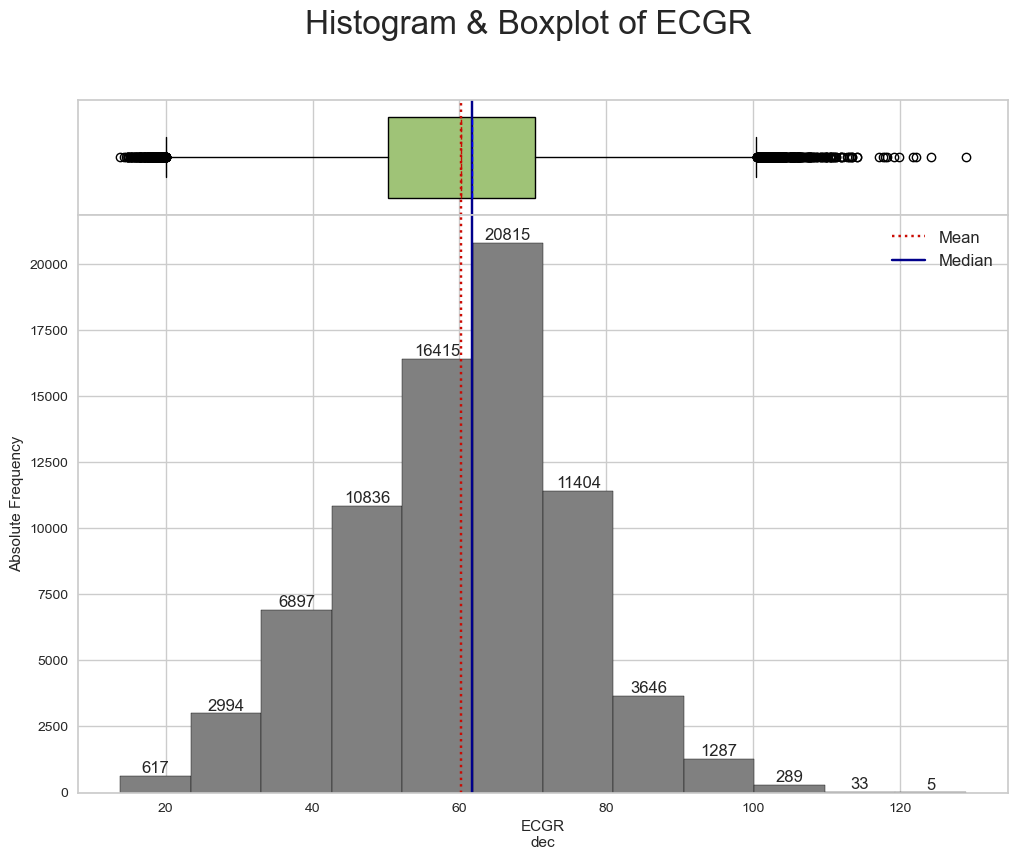

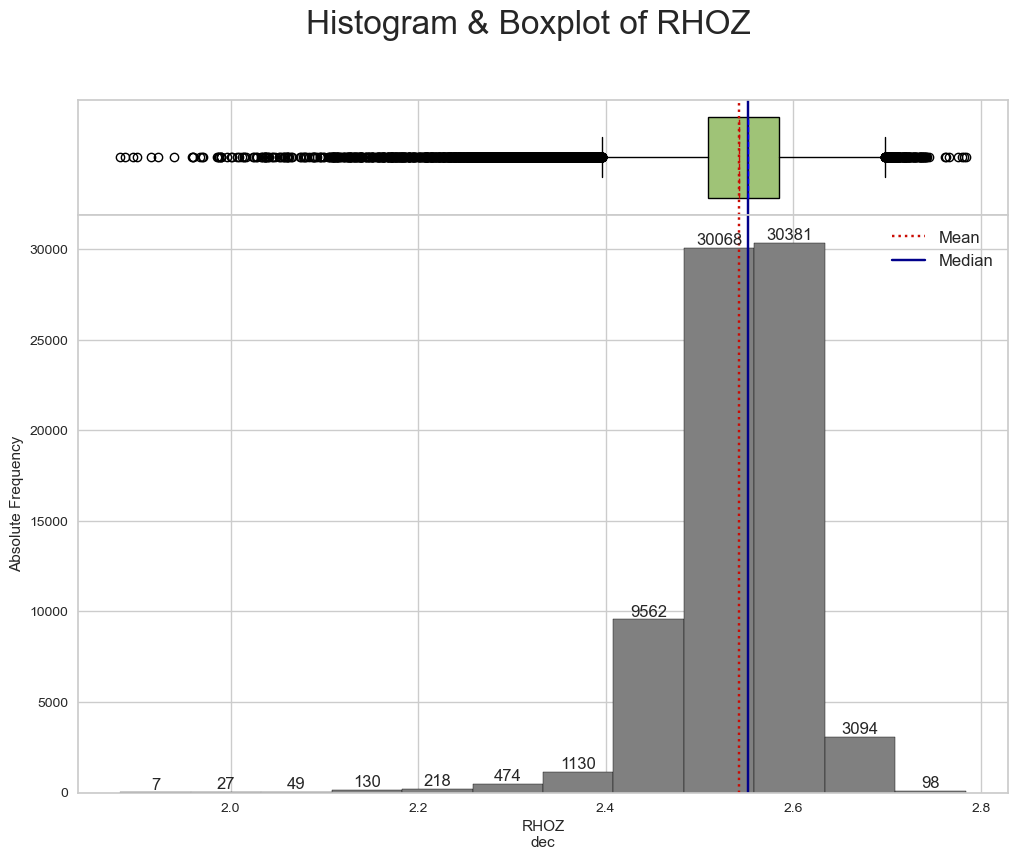

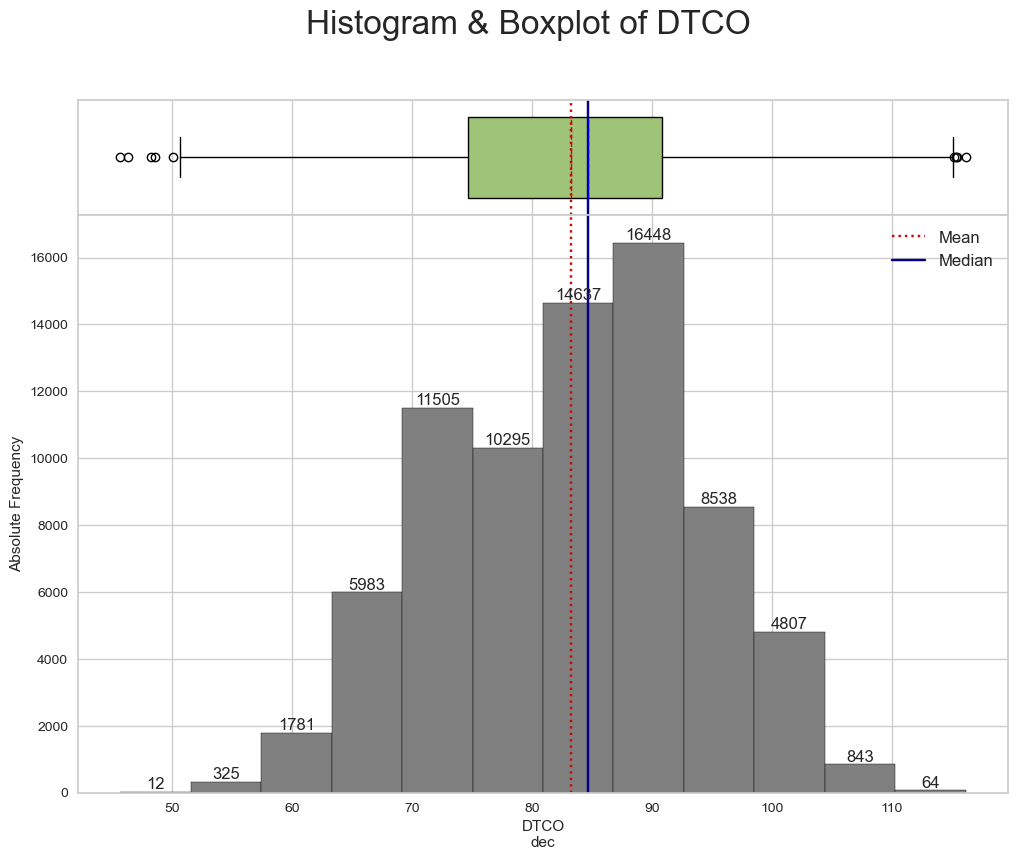

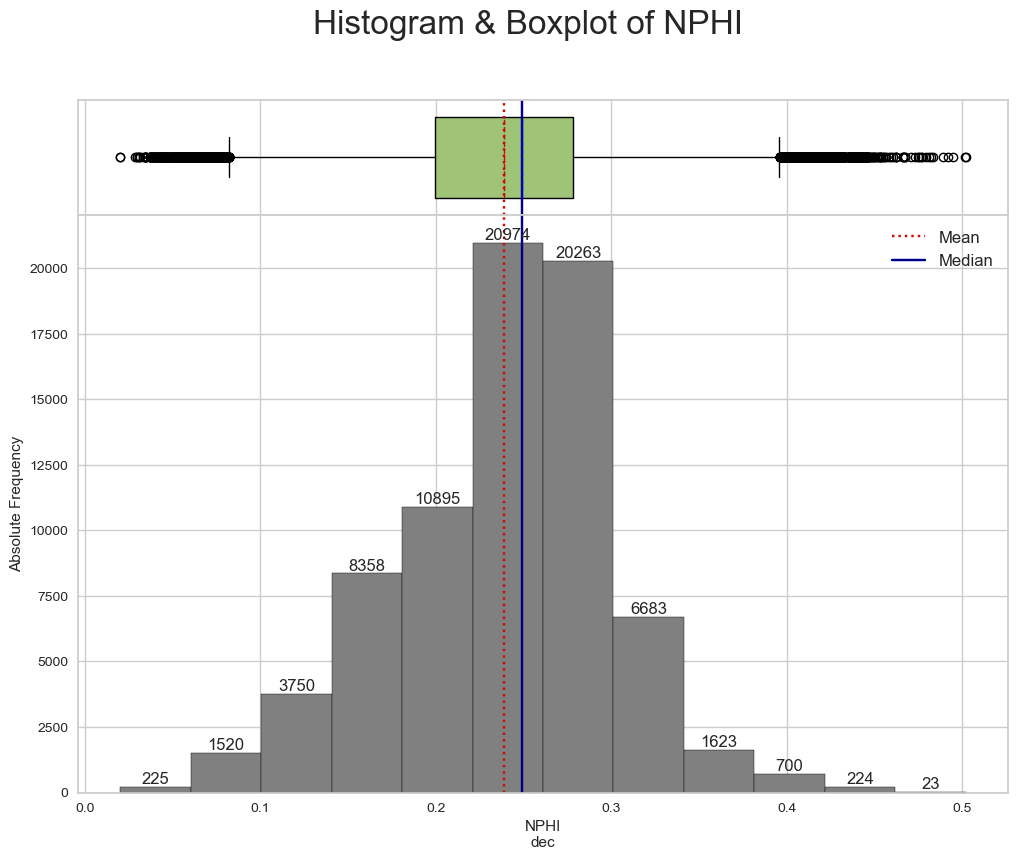

In [7]:
for log in Well_logs:
    fig, axs = Plot_Hist(df_CHTC[log], 12, 'dec', 12);
    fig.savefig(currdir + '\Resultados\\Histograma_%s.png' % log, 
                format="png", bbox_inches="tight", facecolor='white',dpi=300);

**Bivariate Analysis**

In [8]:
print('ECGR vs RHOZ')
print('Kendall ',kendalltau(df_CHTC['ECGR'],df_CHTC['RHOZ'])[0])
print('Pearson ',pearsonr(df_CHTC['ECGR'],df_CHTC['RHOZ'])[0])
print('Spearman ',spearmanr(df_CHTC['ECGR'],df_CHTC['RHOZ'])[0])

print('ECGR vs DTCO')
print('Kendall ',kendalltau(df_CHTC['ECGR'],df_CHTC['DTCO'])[0])
print('Pearson ',pearsonr(df_CHTC['ECGR'],df_CHTC['DTCO'])[0])
print('Spearman ',spearmanr(df_CHTC['ECGR'],df_CHTC['DTCO'])[0])

print('ECGR vs NPHI')
print('Kendall ',kendalltau(df_CHTC['ECGR'],df_CHTC['NPHI'])[0])
print('Pearson ',pearsonr(df_CHTC['ECGR'],df_CHTC['NPHI'])[0])
print('Spearman ',spearmanr(df_CHTC['ECGR'],df_CHTC['NPHI'])[0])

print('RHOZ vs DTCO')
print('Kendall ',kendalltau(df_CHTC['RHOZ'],df_CHTC['DTCO'])[0])
print('Pearson ',pearsonr(df_CHTC['RHOZ'],df_CHTC['DTCO'])[0])
print('Spearman ',spearmanr(df_CHTC['RHOZ'],df_CHTC['DTCO'])[0])

print('RHOZ vs NPHI')
print('Kendall ',kendalltau(df_CHTC['RHOZ'],df_CHTC['NPHI'])[0])
print('Pearson ',pearsonr(df_CHTC['RHOZ'],df_CHTC['NPHI'])[0])
print('Spearman ',spearmanr(df_CHTC['RHOZ'],df_CHTC['NPHI'])[0])

print('DTCO vs NPHI')
print('Kendall ',kendalltau(df_CHTC['DTCO'],df_CHTC['NPHI'])[0])
print('Pearson ',pearsonr(df_CHTC['DTCO'],df_CHTC['NPHI'])[0])
print('Spearman ',spearmanr(df_CHTC['DTCO'],df_CHTC['NPHI'])[0])

ECGR vs RHOZ
Kendall  -0.2776544231472127
Pearson  -0.3552143813959357
Spearman  -0.3984028820778673
ECGR vs DTCO
Kendall  0.565247796897143
Pearson  0.7809713467812326
Spearman  0.7603981912067773
ECGR vs NPHI
Kendall  0.4685965531103177
Pearson  0.6599421149619534
Spearman  0.64129572084903
RHOZ vs DTCO
Kendall  -0.5128956675287792
Pearson  -0.6050306188701624
Spearman  -0.6920945800020811
RHOZ vs NPHI
Kendall  -0.43327000185072295
Pearson  -0.5550717508040275
Spearman  -0.6024479800937128
DTCO vs NPHI
Kendall  0.6193695151221287
Pearson  0.7953850507386939
Spearman  0.8000361090845972


### Univariate outlier analysis.

Univariate outliers were temporarily removed to explore the behaviour of the data; the following plots show the comparison between the original distribution and the distribution without outliers. The criteria used to deem a data point as an outlier was Tukey's criteria.

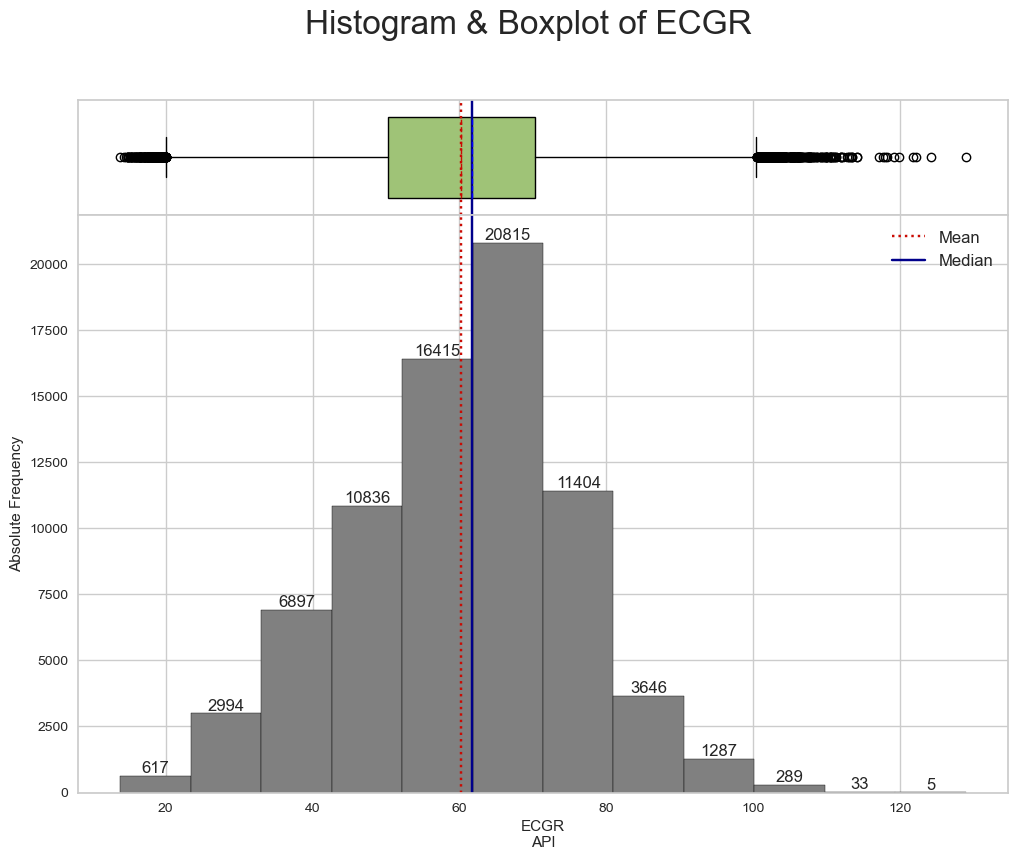

In [9]:
Plot_Hist(df_CHTC['ECGR'], 12, 'API', 12);

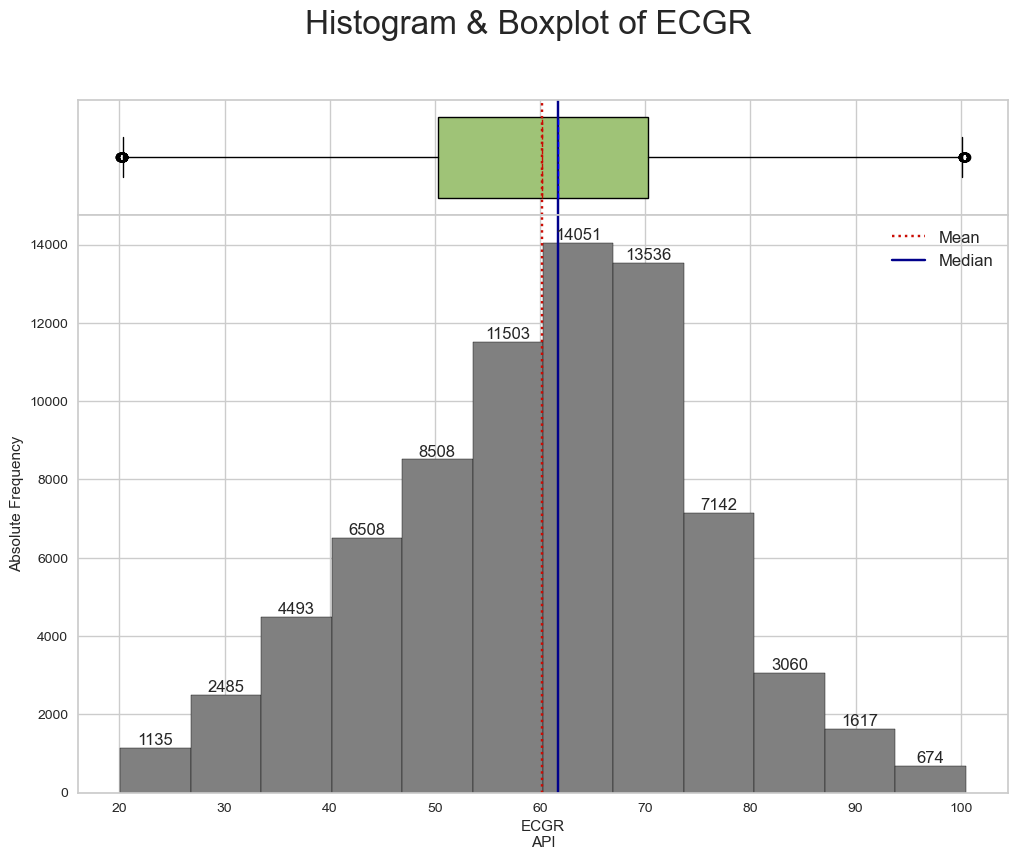

In [10]:
df_temp = Remove_Outliers(df_CHTC, 'ECGR')
Plot_Hist(df_CHTC[df_CHTC['outlier_ECGR'] == 0]['ECGR'], 12, 'API', 12);

### Multivariate outlier analysis.

Considering that clustering methods rely on viewing the data space as a whole rather than relying on single variables, a multivariate outlier analysis was conducted to identify the multivariate analysis. The following plots show the results of using the Local Outlier Factor (LOF) to estimate multivariate outliers, which are marked afterwards.

In [11]:
clf = LocalOutlierFactor(n_neighbors=75)
y_pred = clf.fit_predict(df_CHTC[['ECGR','RHOZ','DTCO','NPHI']])
X_scores = clf.negative_outlier_factor_

In [12]:
n_inliers = (y_pred == 1).sum(); print(f"Number of inliers: {n_inliers}")
n_outliers = (y_pred == -1).sum(); print(f"Number of outliers: {n_outliers}")
n_total = n_inliers + n_outliers; print(f"Total: {n_total}")

Number of inliers: 74934
Number of outliers: 304
Total: 75238


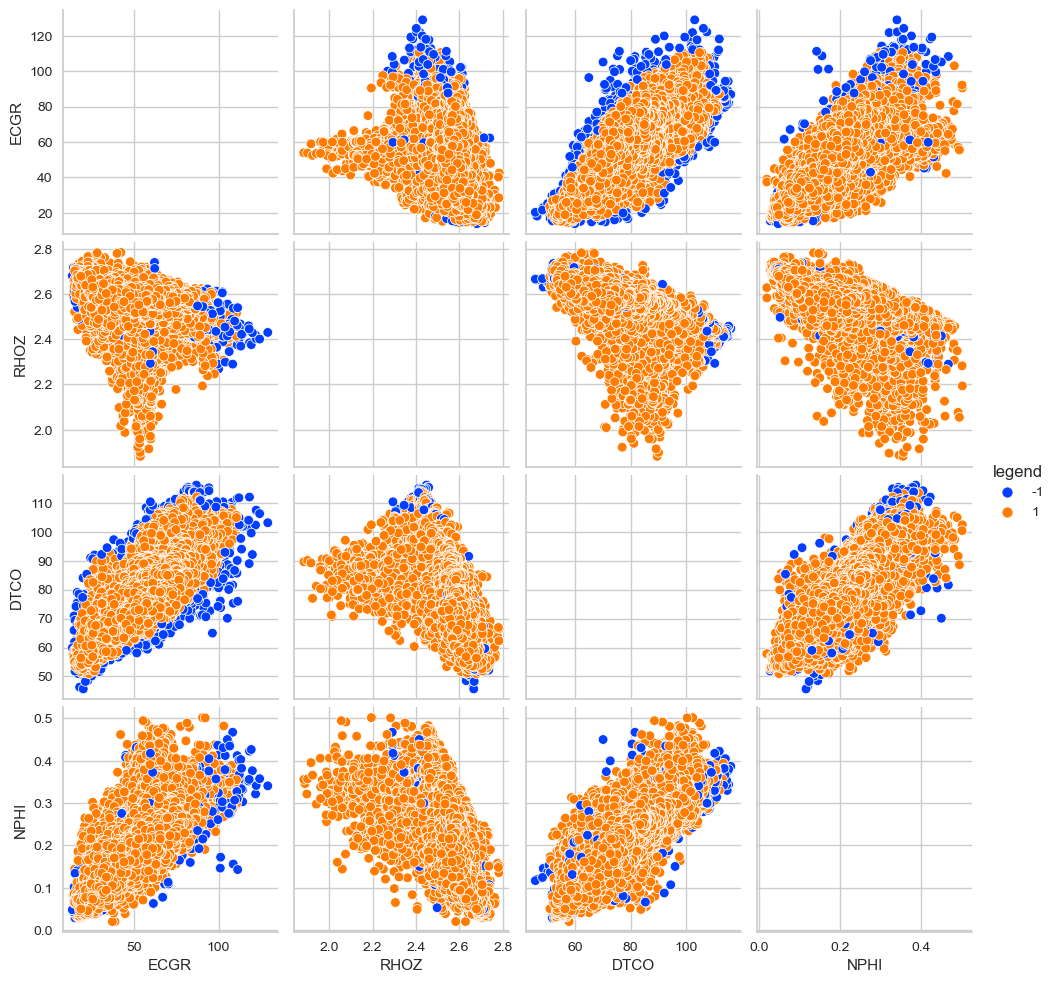

In [13]:
sns.color_palette('bright')
data = df_CHTC[['ECGR','RHOZ','DTCO','NPHI']].copy()
data.columns=['ECGR','RHOZ','DTCO','NPHI']
data['legend'] = y_pred
sns.pairplot(data, hue='legend', palette='bright',diag_kind='none')
#plt.show()
plt.savefig(currdir + '\Resultados\\Outliers.png', format="png", bbox_inches="tight", facecolor='white')

In [14]:
#ds_numpy = df_CHTC[['ECGR','RHOZ','DTCO','NPHI']].to_numpy()
#colors = np.array(["#377eb8", "#ff7f00"])
#good = ds_numpy[y_pred == 1]
#outliers = ds_numpy[y_pred == -1]

#plt.title("Local Outlier Factor (LOF)")

#plt.scatter(good[:, 0], good[:, 1], color='r', s=6.0, label="Inliers")
#plt.scatter(outliers[:, 0], outliers[:, 1], color='b', s=12.0, label="Outliers")

#legend = plt.legend()
#plt.xlabel('ECGR')
#plt.ylabel('RHOZ')
#plt.show()
#plt.savefig(currdir + '\Resultados\\LOC_Plot.png',format="png", bbox_inches="tight", facecolor='white', dpi=300);

In [15]:
df_CHTC_inliers = df_CHTC[y_pred == 1]

## Data Standardisation.

Prior to applying the clustering algorithm, data needs to be standardised to equalise the range of the input data. This process is done by subtracting the mean and dividing by the variance so the resulting distribution for each variable will have zero mean and variance close to one. Code for global standardisation and well-to-well standardisation is included. Lastly, to ensure the process was done correctly, statistics of the standardised variables are included; please note the mean and the variance of the transformed data.

**Standarization by well**

In [16]:
Pozos = list(df_CHTC_inliers['Well_ID'].value_counts(sort=False).index)

In [17]:
resultado = []
scaler = StandardScaler()
for pozo in Pozos:
    standarized_data = scaler.fit_transform(df_CHTC_inliers[df_CHTC_inliers['Well_ID'] == pozo][Well_logs])
    resultado = resultado + standarized_data.tolist()
df_standard = pd.DataFrame(resultado, columns=Well_logs, index=df_CHTC_inliers.index)
Estadigrafos(df_standard,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,74934.00,74934.00,74934.00,74934.00
Minimum,-5.47,-10.67,-3.88,-4.49
1st quartile,-0.61,-0.65,-0.78,-0.68
Median,0.22,0.02,0.19,0.23
Mean,-0.00,0.00,0.00,-0.00
3rd quartile,0.71,0.65,0.74,0.71
Maximum,3.72,5.40,3.29,5.55
Range,9.19,16.06,7.17,10.04
IQR,1.33,1.30,1.53,1.39
Variance,1.00,1.00,1.00,1.00


**Global standarization**

In [18]:
#scaler = StandardScaler()
#df_original_Standard = scaler.fit_transform(df_inliers[registros_geofisicos]) 
#df_standard = pd.DataFrame(df_original_Standard, columns=registros_geofisicos, index=df_inliers.index)
#for registro in registros_geofisicos:
#    fig, axs = Plot_Hist(df_standard[registro], 12, 'dec', 12);
#    fig.savefig(currdir + '\Resultados\\Histograma_%s_std.png' % registro,
#                format="png", bbox_inches="tight", facecolor='white', dpi=300);

In [19]:
#df_CHTC_standard = pd.concat([df_CHTC['DEPT'],df_CHTC['Well_ID'],df_standard], axis=1)
#df_CHTC_standard.head(5)

## Data splitting.

Although a 75,000-sample data set might not seem lengthy at first, several practical applications require the use of many more samples; it is a good practice to extract a representative sample from the bigger data set to reduce the computational time of the clustering process.

In this particular case, 25% of the data was extracted (random samples) to conduct the clustering process. The boxplot and statistics for both data sets prove this sample's representativeness.

In [20]:
df_CHTC_short = df_CHTC_inliers.sample(frac=0.25, random_state=5, axis=0)
df_standard_short = df_standard.sample(frac=0.25, random_state=5, axis=0)

In [21]:
Estadigrafos(df_standard,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,74934.00,74934.00,74934.00,74934.00
Minimum,-5.47,-10.67,-3.88,-4.49
1st quartile,-0.61,-0.65,-0.78,-0.68
Median,0.22,0.02,0.19,0.23
Mean,-0.00,0.00,0.00,-0.00
3rd quartile,0.71,0.65,0.74,0.71
Maximum,3.72,5.40,3.29,5.55
Range,9.19,16.06,7.17,10.04
IQR,1.33,1.30,1.53,1.39
Variance,1.00,1.00,1.00,1.00


In [22]:
Estadigrafos(df_standard_short,['ECGR','RHOZ','DTCO','NPHI']).round(2)

,ECGR,RHOZ,DTCO,NPHI
Samples,18734.00,18734.00,18734.00,18734.00
Minimum,-4.17,-9.75,-3.88,-4.03
1st quartile,-0.62,-0.64,-0.79,-0.68
Median,0.23,0.03,0.18,0.23
Mean,-0.00,-0.01,-0.00,0.01
3rd quartile,0.71,0.64,0.74,0.71
Maximum,3.72,4.91,3.16,4.22
Range,7.89,14.66,7.04,8.24
IQR,1.33,1.28,1.53,1.40
Variance,1.00,0.99,1.00,1.00


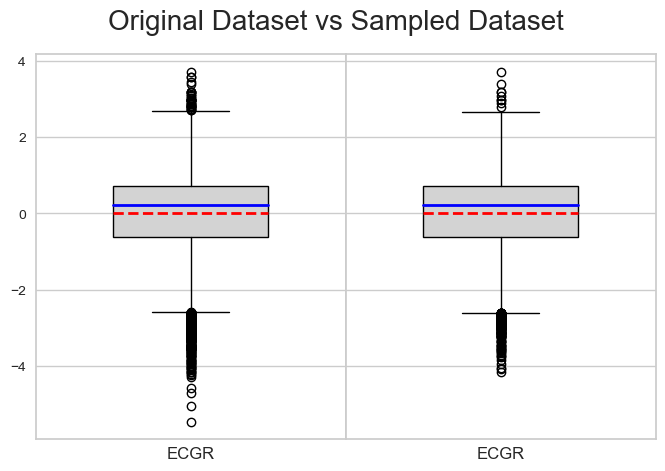

In [23]:
label = 'ECGR'
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)
fig.suptitle('Original Dataset vs Sampled Dataset', size=20, y=0.97)
plt.subplots_adjust(wspace=0, hspace=0)

## Original Dataframe
axs[0].boxplot(df_standard[label],vert=True, meanline=True, showmeans=True, widths=0.50, patch_artist=True,
                 boxprops={'facecolor':'lightgrey'}, medianprops={'color':'blue','linewidth':2},
                 meanprops={'color':'red','linewidth':2})
axs[0].set_title('%s' %label, y=-0.07)
axs[0].set_xticks([])

## Sampled Dataframe
axs[1].boxplot(df_standard_short[label],vert=True, meanline=True, showmeans=True, widths=0.50, patch_artist=True,
                 boxprops={'facecolor':'lightgrey'}, medianprops={'color':'blue','linewidth':2},
                 meanprops={'color':'red','linewidth':2})
axs[1].set_title('%s' %label, y=-0.07)
axs[1].set_xticks([])
fig.savefig(currdir + '\Resultados\\Datasets.png', format="png", bbox_inches="tight", facecolor='white')

## Determination of the optimal k.

A crucial step in the clustering analysis implementation is to determine the optimum number of clusters, which is an input for most clustering algorithms. This is achieved by brute force calculating metrics for several values of k so the performance of each k can be compared and the optimal k can be found. It is essential to be mindful that the time it takes to build each of these graphs is much larger than the time required to estimate the clusters once the optimal k has been chosen. Therefore, the code is commented, and the images that were previously generated are loaded into this notebook.

**Elbow Method**

In [24]:
#model = KMeans(n_init=10, random_state=42)
#visualizer = KElbowVisualizer(model, k=(2,20))
#visualizer.fit(df_standard_short[Well_logs])
#visualizer.show()
#plt.savefig(currdir + '\\Resultados\\Elbow.png', format="png", bbox_inches="tight", facecolor='white')

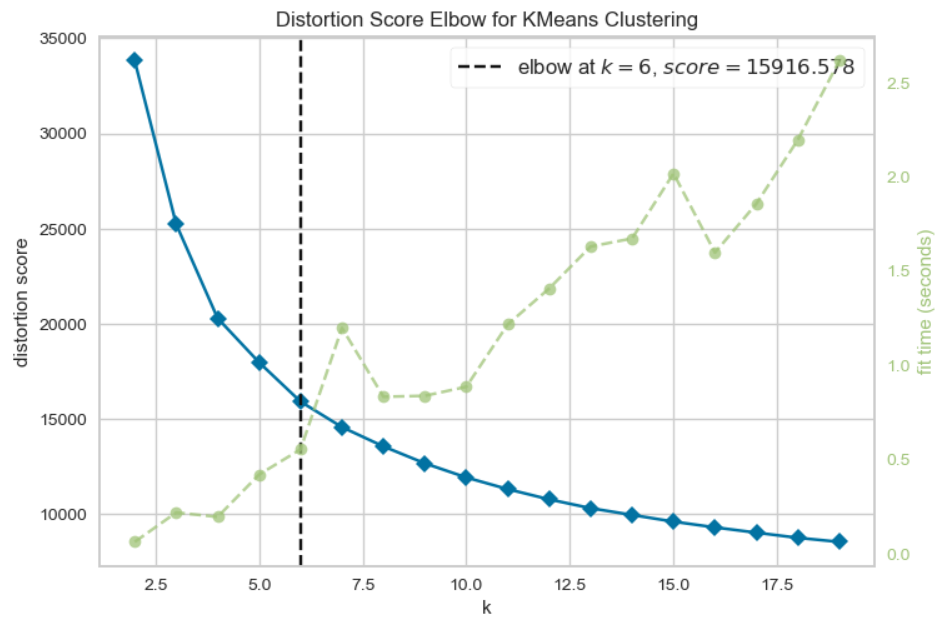

In [25]:
image = Image.open(currdir + '\\Resultados\\Elbow.png')
image

**Silhouette Method**

In [26]:
#Silhouette_plots(df_standard_short[Well_logs],[3,6,12,13])

In [27]:
#Silhouette(df_standard_short[Well_logs],ks=range(2, 20))
#plt.savefig(currdir + '\Resultados\\Silhouete.png', format="png", bbox_inches="tight", facecolor='white')

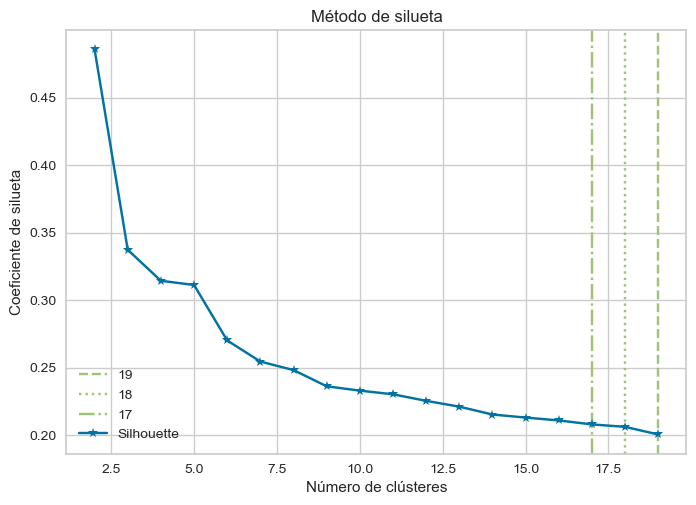

In [28]:
image = Image.open(currdir + '\\Resultados\\Silhouete.png')
image

**Calinski-Harabasz Index (Variance Ratio Criterion, VRC)**

In [29]:
#CH_Index(df_standard_short[Well_logs],ks=range(2,30))
#plt.savefig(currdir + '\Resultados\\CH_Index.png', format="png", bbox_inches="tight", facecolor='white')

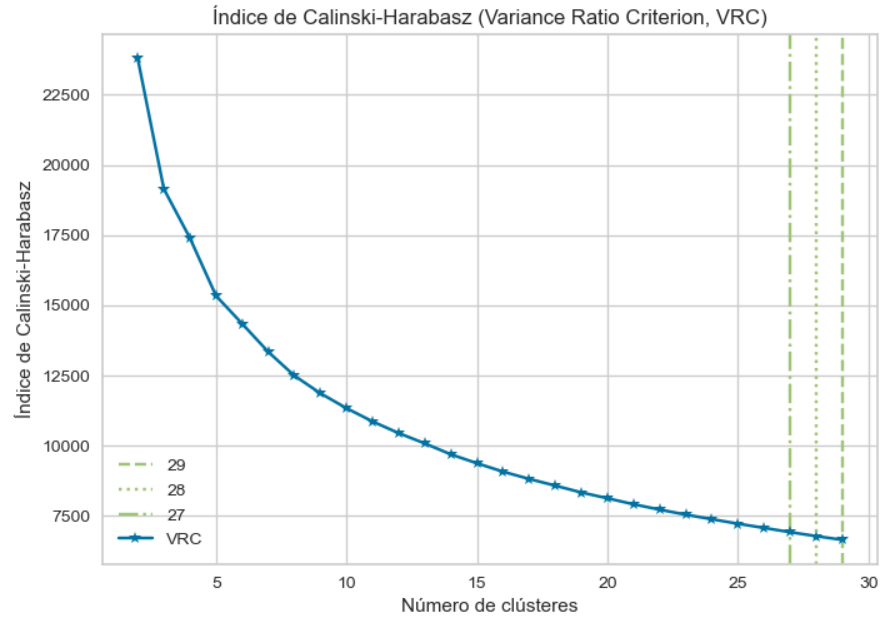

In [30]:
image = Image.open(currdir + '\\Resultados\\CH_Index.png')
image

**Davies-Bouldin Index**

In [31]:
#DB_Index(df_standard_short[Well_logs],ks=range(2, 20))
#plt.savefig(currdir + '\Resultados\\DB_Index.png', format="png", bbox_inches="tight", facecolor='white')

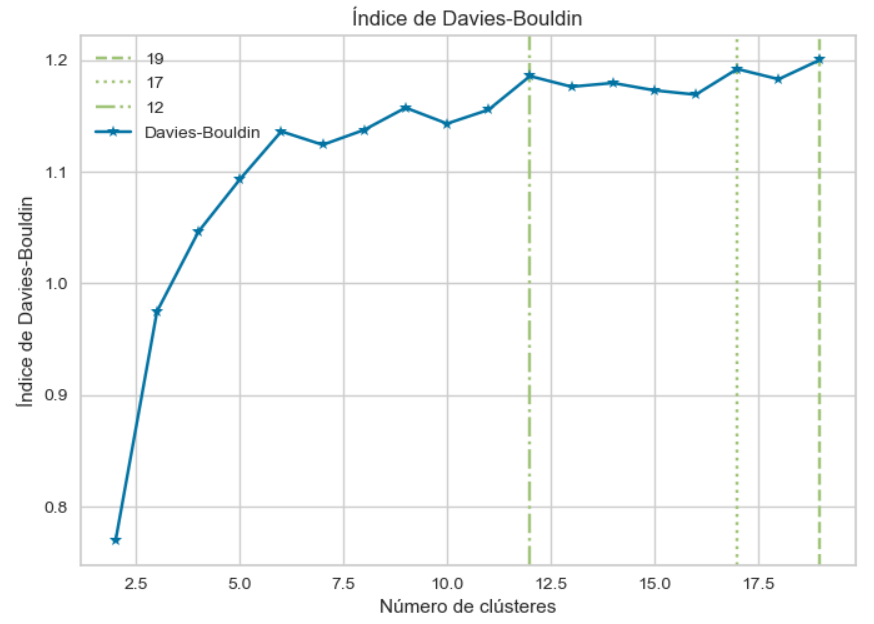

In [32]:
image = Image.open(currdir + '\\Resultados\\DB_Index.png')
image

**Gap Statistics Method**

In [33]:
#df_temp = optimalK(df_standard_short[Well_logs], nrefs=5, maxClusters=20)
#plt.plot(df_temp['clusterCount'], df_temp['gap'], linestyle='--', marker='o', color='b');
#plt.xlabel('K');
#plt.ylabel('Gap Statistic');
#plt.title('Gap Statistic vs. K');
#plt.savefig(currdir + '\Resultados\\Gap.png', format="png", bbox_inches="tight", facecolor='white')

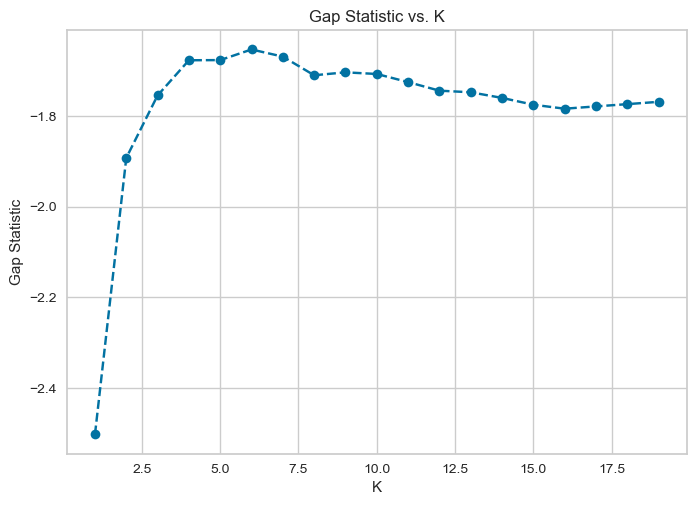

In [34]:
image = Image.open(currdir + '\\Resultados\\Gap.png')
image

## SOM application (4 clusters).

In [36]:
#start_time = time.time()
som = SOM(4, 1)
#som.fit(df_standard_short[Well_logs].to_numpy(), 7000, save_e=True, interval=100)
#finish_time = time.time(); tiempo_entrenamiento_4C = finish_time - start_time
#print('El tiempo que tarda entrenar es de ', tiempo_entrenamiento_4C, 'segundos') 
som.load(filename='Resultados/SOM_Entrenado_4_Clases.dat')

In [37]:
som.som_error(df_standard_short[Well_logs].to_numpy())

0.9265019050105632

In [38]:
som.plot_error_history(filename='Resultados/som_error_4_Clases.png', color='green')
#som.save(filename='Resultados/SOM_Entrenado_4_Clases.dat')

Error history plot done!


In [39]:
Class_4_Predict = som.winner_neurons(df_standard_short[Well_logs].to_numpy()) 
df_4 = pd.DataFrame(Class_4_Predict[:,0], columns=['SOM_4_Classes'], index=df_standard_short.index)

Calculating neuron indices for all data points...


**Data reclassification**

In [40]:
#df_4.replace({0:3,1:2,2:0,3:1},inplace=True)
df_4.replace({2:3,3:2},inplace=True)

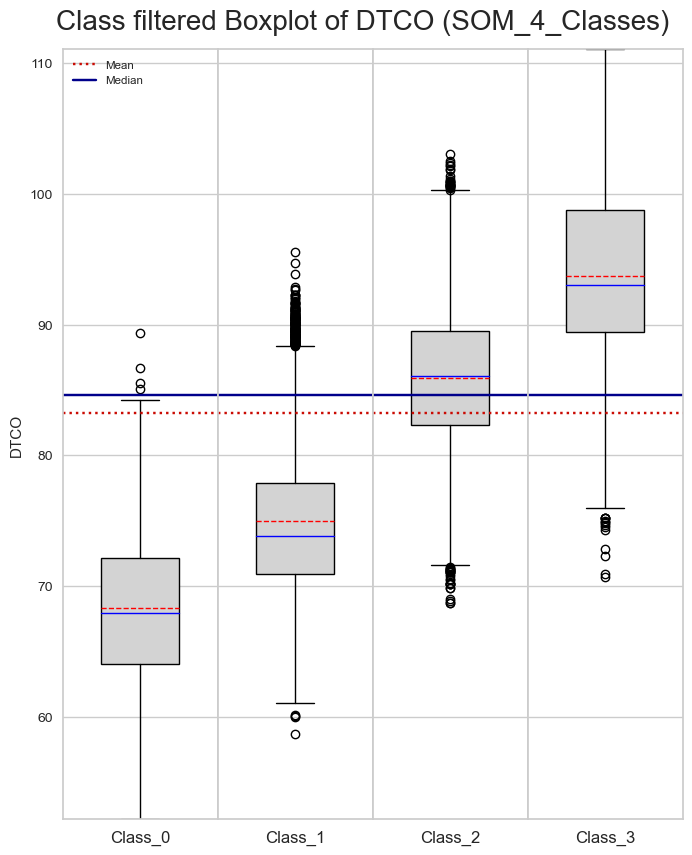

In [41]:
df_Class4 = pd.concat([df_CHTC_short,df_4], axis=1)
df_Class4_standard = pd.concat([df_standard_short,df_4], axis=1)

Class_Boxplots(df_Class4, 'DTCO', 'SOM_4_Classes');
plt.savefig(currdir + '\Resultados\\Boxplot_por_clase.png', format="png", bbox_inches="tight", facecolor='white')

### Output file.

In [42]:
df_Clasificado = pd.concat([df_CHTC,df_4], axis=1)
df_Clasificado.to_csv(currdir + '\\Resultados\\Electrofacies_SOM.csv', na_rep=-999.25, index=False)

## Result Analysis.

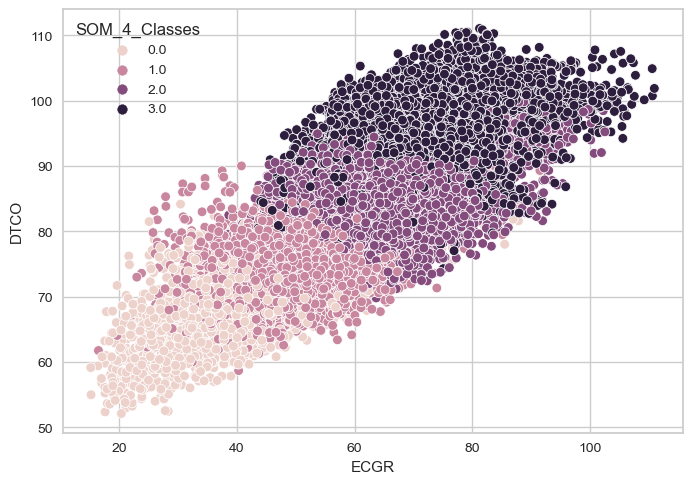

In [43]:
fig = sns.scatterplot(data=df_Clasificado, x='ECGR', y='DTCO', hue='SOM_4_Classes').get_figure()
fig.savefig(currdir + '\Resultados\\Crossplot_ECGR_DTCO.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);

<Axes: xlabel='NPHI', ylabel='DTCO'>

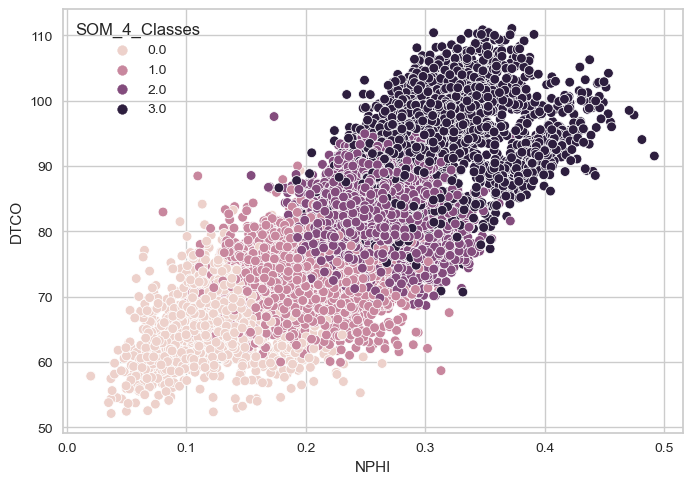

In [44]:
sns.scatterplot(data=df_Clasificado, x='NPHI', y='DTCO', hue='SOM_4_Classes')

## Electrofacies estimation.

 To use the estimated clusters to build electrofacies, an analysis of the clusters was conducted to find the geological context where the clusters fit. This is done by analysing the resulting clusters and their statistics and boxplots to correlate them with the context based on the observed behaviour of the clusters.

**Class count**

In [51]:
df_Class4['SOM_4_Classes'].value_counts()

2    6772
3    5108
1    4630
0    2224
Name: SOM_4_Classes, dtype: int64

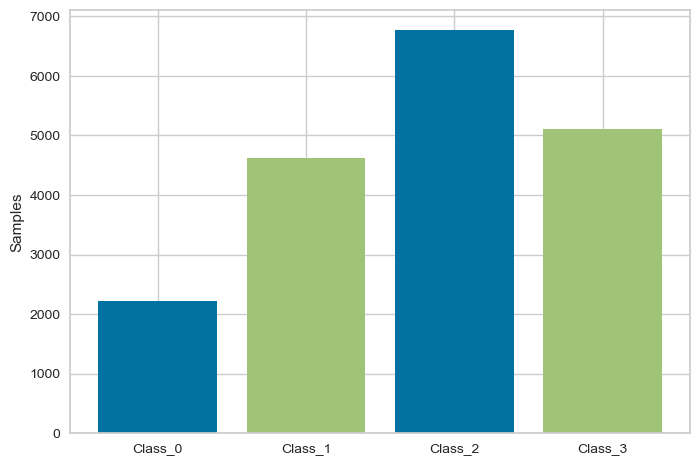

In [45]:
temp = df_Clasificado['SOM_4_Classes'].value_counts().sort_index()
plt.bar(x=temp.index, height=temp.values, color=['b','g','b','g'], tick_label=['Class_0','Class_1','Class_2','Class_3'])
plt.ylabel("Samples")
plt.savefig(currdir + '\Resultados\\ClassCount.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);

**Electrofacies 0 (Sand)**

Electrofacies 0 corresponds to the class with the fewest samples; the low ECGR values suggest that these electrofacies have the least shaliness. Considering the lithology of the zone, these electrofacies are likely to have the highest sand content, considering the median of the well logs.  

In [46]:
df_temp = Estadigrafos(df_Clasificado[df_Clasificado['SOM_4_Classes'] == 0], ['ECGR','RHOZ','DTCO','NPHI']).round(3)
df_temp.to_csv(currdir + '\Resultados\\Estadigrafos_Class0.csv')
df_temp

,ECGR,RHOZ,DTCO,NPHI
Samples,2224.000,2224.000,2224.000,2224.000
Minimum,15.147,2.409,52.143,0.020
1st quartile,31.085,2.578,64.045,0.110
Median,37.884,2.610,67.948,0.139
Mean,38.965,2.606,68.332,0.140
3rd quartile,44.419,2.636,72.116,0.167
Maximum,87.807,2.766,89.322,0.264
Range,72.660,0.357,37.179,0.244
IQR,13.334,0.058,8.071,0.057
Variance,140.320,0.002,38.957,0.002


**Electrofacies 1 (Shaly-Sand)**

The second less abundant electrofacies is the one made of class 1 points. A glance at the ECGR graph reveals that this electrofacies' median is slightly higher than electrofacies' 0, which suggests that the shaliness is increasing. The density log, neutron porosity, and transit time also suggest that shaliness might be increasing. Therefore, this electrofacies is closer to a shaly sand than electrofacies 0.

In [47]:
df_temp = Estadigrafos(df_Clasificado[df_Clasificado['SOM_4_Classes'] == 1], ['ECGR','RHOZ','DTCO','NPHI']).round(3)
df_temp.to_csv(currdir + '\Resultados\\Estadigrafos_Class1.csv')
df_temp

,ECGR,RHOZ,DTCO,NPHI
Samples,4630.000,4630.000,4630.000,4630.000
Minimum,16.464,2.175,58.700,0.081
1st quartile,43.227,2.536,70.891,0.173
Median,50.318,2.570,73.822,0.195
Mean,50.804,2.562,74.937,0.199
3rd quartile,57.097,2.597,77.888,0.224
Maximum,92.886,2.720,95.521,0.320
Range,76.421,0.545,36.821,0.239
IQR,13.870,0.061,6.997,0.051
Variance,115.629,0.003,36.306,0.001


**Electrofacies 2 (Sandy-Shale)**

Class 2 is the one with the most data points. The ECGR values suggest the shale content is higher than the previous electrofacies, but in contrast with electrofacies 3, this facies still has a lower value of ECGR; hence why this electrofacies is deemed as a shaly sand facies. A glance at the other logs supports the hypothesis, this facies is not the highest in DTCO nor NPHI, which might suggest there are still shalier rocks in the dataset.

In [48]:
df_temp = Estadigrafos(df_Clasificado[df_Clasificado['SOM_4_Classes'] == 2], ['ECGR','RHOZ','DTCO','NPHI']).round(3)
df_temp.to_csv(currdir + '\Resultados\\Estadigrafos_Class2.csv')
df_temp

,ECGR,RHOZ,DTCO,NPHI
Samples,6772.000,6772.000,6772.000,6772.000
Minimum,38.598,2.330,68.669,0.154
1st quartile,59.483,2.530,82.345,0.239
Median,65.559,2.558,86.045,0.255
Mean,65.460,2.551,85.925,0.257
3rd quartile,70.592,2.579,89.533,0.274
Maximum,102.495,2.686,103.020,0.373
Range,63.897,0.356,34.351,0.218
IQR,11.110,0.050,7.188,0.034
Variance,86.071,0.002,32.729,0.001


**Electrofacies 3 (Shale)**

These electrofacies correspond to the highest values of ECGR, NPHI, and DTCO, which suggests that, in contrast with the previous electrofacies, these facies are the shaliest of the dataset. A glance at the RHOZ log shows that these electrofacies are the least dense, which is consistent with them being likely to be shale with a very low content of sand.

In [49]:
df_temp = Estadigrafos(df_Clasificado[df_Clasificado['SOM_4_Classes'] == 3], ['ECGR','RHOZ','DTCO','NPHI']).round(3)
df_temp.to_csv(currdir + '\Resultados\\Estadigrafos_Class3.csv')
df_temp

,ECGR,RHOZ,DTCO,NPHI
Samples,5108.000,5108.000,5108.000,5108.000
Minimum,43.609,1.888,70.720,0.178
1st quartile,63.283,2.455,89.429,0.269
Median,70.446,2.501,93.018,0.287
Mean,70.989,2.484,93.738,0.296
3rd quartile,77.306,2.530,98.795,0.316
Maximum,110.897,2.597,111.058,0.492
Range,67.288,0.709,40.339,0.314
IQR,14.023,0.075,9.366,0.047
Variance,121.047,0.005,38.694,0.002


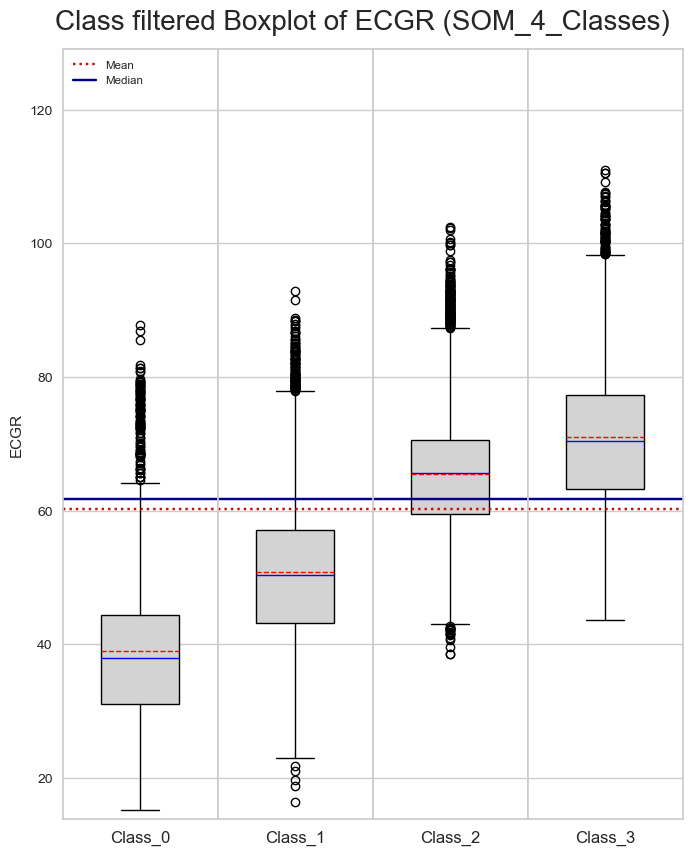

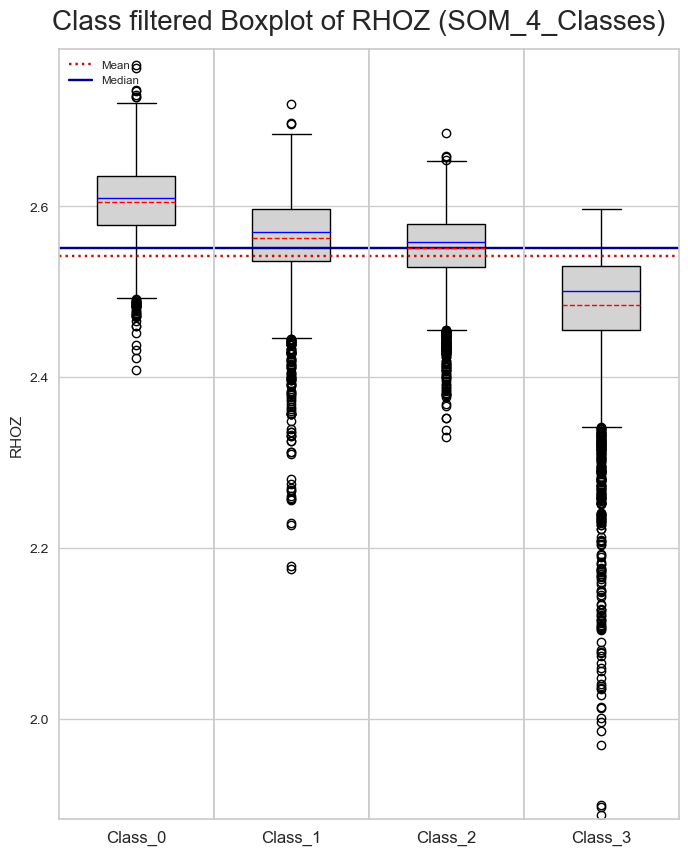

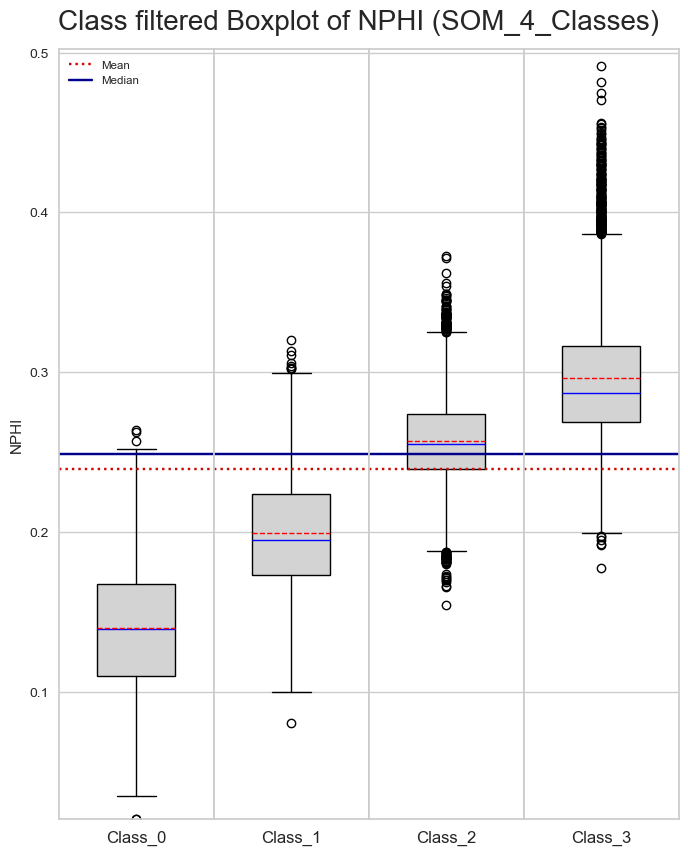

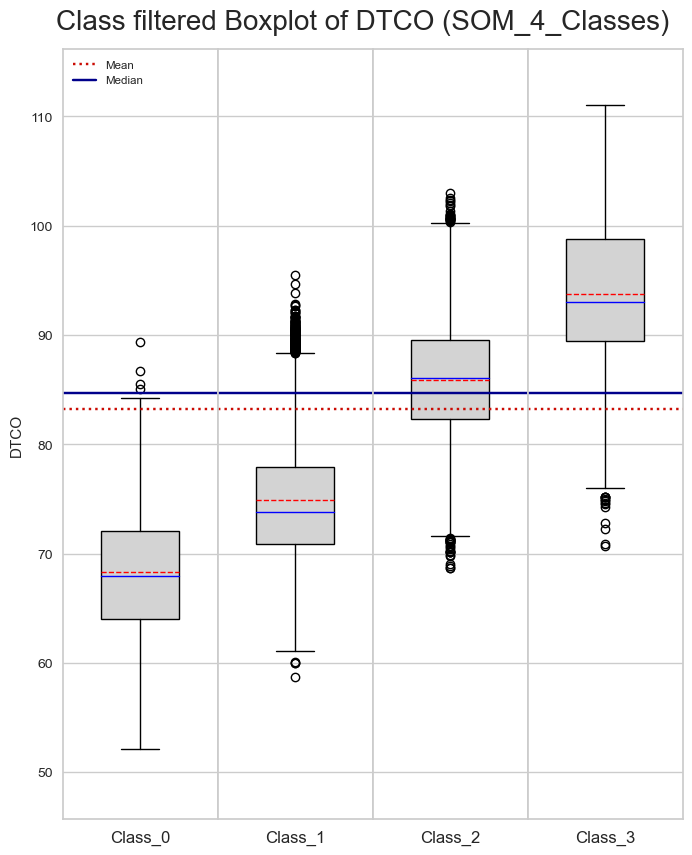

In [50]:
Clases = ['SOM_4_Classes']
Registros_Boxplots = ['ECGR','RHOZ','NPHI','DTCO']
for registro in Registros_Boxplots:
    for clase in Clases:
        fig, axs = Class_Boxplots(df_Clasificado, registro, clase);
        fig.savefig(currdir + '\Resultados\\%s_Boxplot_for_%s.png' % (registro, clase), 
                    format="png", bbox_inches="tight", facecolor='white', dpi=300);